### Import section

In [18]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [19]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
# !pip install visualkeras
import tensorflow as tf
#import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
#from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
# General parameters
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# pip install opencv-python
import cv2
import os

folder_path = "/kaggle/input/brain-tumor-mri-dataset/Training"             # base/root directory

no_tumor = os.listdir(folder_path + '/notumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
#craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [23]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/notumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [24]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [25]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [26]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [27]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(5712, 240, 240, 3) (5712,)


### Deep Feature Extraction

In [28]:
from tensorflow.keras.applications import DenseNet201

model = DenseNet201(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

from tensorflow.keras.applications.densenet import preprocess_input

dataset = preprocess_input(np.array(dataset))

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

subdirectories = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Create a generator for the images in the subdirectories
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
#     class_mode=None,
    shuffle=False,
    classes=subdirectories)

Found 5712 images belonging to 4 classes.


In [33]:
features = model.predict(generator, verbose=1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 253ms/step


In [34]:
 print(len(features))

5712


In [35]:
print("Number of extracted deep features:", features.shape[1])

Number of extracted deep features: 7


In [36]:
np.save('extracted_features.npy', features)

In [37]:
features.shape

(5712, 7, 7, 1920)

In [38]:
from tensorflow.keras.layers import Input

# Flatten the features to use them for classification
features_flatten = np.reshape(features, (features.shape[0], -1))

# Define the labels for the images in the subdirectories
labels = generator.classes

In [39]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

In [40]:
print(train_features.max(), train_features.min())
print(test_features.max(), test_features.min())

# train_features = train_features/255
# test_features = test_features/255
# print(train_features.max(), train_features.min())
# print(test_features.max(), test_features.min())

42.81535 0.0
40.09885 0.0


### SVM

In [41]:
from sklearn.svm import SVC

# Initialize and train an SVC model
svc_model = SVC(kernel='linear')  # You can use other kernels as well
svc_model.fit(train_features, train_labels)

# Predict the labels of the testing set using the trained SVC model
predicted_labels = svc_model.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

     notumor       0.99      0.99      0.99       346
      glioma       0.98      0.97      0.97       251
  meningioma       0.92      0.94      0.93       247
   pituitary       0.98      0.97      0.98       299

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



In [42]:
print(matrix)

[[341   0   5   0]
 [  0 243   8   0]
 [  4   6 232   5]
 [  0   0   8 291]]


In [43]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.9599020172332955

In [45]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['notumor', 'glioma', 'meningioma', 'pituitary'],

                     columns = ['notumor', 'glioma', 'meningioma', 'pituitary'])

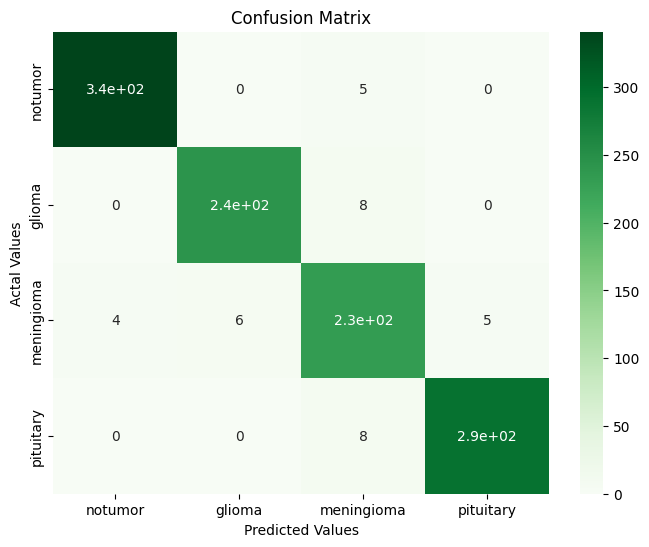

In [46]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [47]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.968503937007874

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.968503937007874

In [49]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.968503937007874

In [50]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.968503937007874

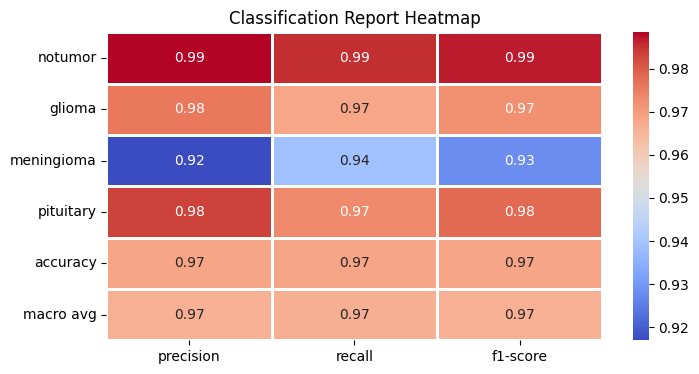

In [52]:
from sklearn.metrics import classification_report
import pandas as pd

class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Generate classification report
report_dict = classification_report(test_labels, predicted_labels, target_names=class_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).T

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", linewidths=1)
plt.title("Classification Report Heatmap")
plt.show()

In [1]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Define correct class labels
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Binarize labels for 4 classes
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Train SVM in One-vs-Rest mode
svm_ovr = OneVsRestClassifier(SVC(kernel="linear", probability=True))
svm_ovr.fit(train_features, label_binarize(train_labels, classes=[0, 1, 2, 3]))
y_score = svm_ovr.decision_function(test_features)

# Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()

NameError: name 'test_labels' is not defined